# Use IMPA to correct RxRx1

Import libraries 

In [ ]:
# Standard library imports
import os
from pathlib import Path

# Third-party library imports
from tutorial_utils import t2np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml 
import torch
from omegaconf import OmegaConf
from tqdm import tqdm

# Local application/library imports
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule

Read the configuration of interest 

In [68]:
path_to_config = "../config_hydra/config/rxrx1_batch.yaml"

In [69]:
# Reading the YAML file
with open(path_to_config, 'r') as file:
    config = yaml.safe_load(file)  # Use safe_load to avoid executing arbitrary code

# Access the loaded data
print(config)

{'task_name': 'rxrx1_batch', 'img_size': 96, 'latent_dim': 100, 'hidden_dim': 512, 'style_dim': 64, 'stochastic': True, 'z_dimension': 16, 'dim_in': 64, 'lambda_reg': 1, 'lambda_cyc': 1, 'lambda_sty': 1, 'lambda_ds': 1, 'total_epochs': 100, 'ds_iter': 100000, 'resume_iter': 0, 'batch_size': 32, 'val_batch_size': 20, 'lr': 0.0001, 'f_lr': 0.0001, 'beta1': 0, 'beta2': 0.99, 'weight_decay': 0.0001, 'num_outs_per_domain': 10, 'single_style': True, 'ood_set': None, 'mol_list': None, 'balanced': False, 'trainable_emb': True, 'dataset_name': 'rxrx1', 'n_channels': 6, 'num_workers': 6, 'seed': 42, 'multimodal': False, 'batch_correction': True, 'batch_key': 'BATCH', 'use_condition_embeddings': False, 'condition_embedding_dimension': None, 'modality_list': ['Compound'], 'image_path': 'project_folder/datasets/rxrx1', 'data_index_path': 'project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', 'embedding_path': None, 'experiment_directory': 'project_folder/experiments/', 'sample_dir': 'sample', 'chec

In [70]:
config["image_path"] = "../" + config["image_path"]
config["data_index_path"] = "../" + config["data_index_path"]

Create an omega config dict

In [71]:
args = OmegaConf.create(config)

#### Initialize data loader

In [72]:
dataloader = CellDataLoader(args)

['transform_cells_bbbc021_six_drugs.ipynb', 'transform_cells_cpg0000_batch_corr.ipynb', 'transform_cells_rxrx1_batch_corr.ipynb', '__pycache__', 'transform_cells_bbbc021_all_unseen_prediction.ipynb', '.ipynb_checkpoints', 'transform_cells_cpg0000_pert_prediction.ipynb', 'tutorial_utils.py']


/home/icb/alessandro.palma/environment/IMPA/IMPA/IMPA/dataset/data_loader.py:110: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(self.data_index_path, index_col=0)


## Initialize model 

In [73]:
checkpoint_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20241126_bb6b22a0-f675-4389-a271-03a93c2c46be_rxrx1_batch"

In [74]:
solver = IMPAmodule(args, checkpoint_dir, dataloader)
solver._load_checkpoint(18)

Number of parameters in generator: 24320518
Number of parameters in style_encoder: 14331200
Number of parameters in discriminator: 14299907
Number of parameters in mapping_network: 7488
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(3, 100)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)


**Check what molecules we have and their encodings**

In [75]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [76]:
dataloader.mol2id

{'U2OS-01': 0, 'U2OS-02': 1, 'U2OS-03': 2}

Let's convert the images to batch 0

In [108]:
# Initilize empty dictionaries 
original = []
transformed = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader.test_dataloader())):
        if batch["mols"][0].item()==1:
            X_ori = batch["X"]
            # z original and z transported
            z = torch.randn(X_ori.shape[0], 1, args.z_dimension).cuda().mean(1)
    
            # Perturbation ID 
            id_pert = 1 * torch.ones(X_ori.shape[0]).long().cuda()
            y = solver.embedding_matrix(id_pert)
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
    
            _, X_generated = solver.nets.generator(X_ori, y)
    
            original.append(t2np(X_ori.detach().cpu(), batch_dim=True))
            transformed.append(t2np(X_generated.detach().cpu(), batch_dim=True))
            
original = np.concatenate(original, axis=0) 
transformed = np.concatenate(transformed, axis=0) 

1714it [00:31, 54.52it/s] 


In [109]:
batch["mols"]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [110]:
batch["y_id"]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

**Plot the results**

Original 0


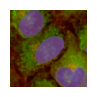

Original 1


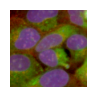

Original 2


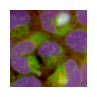

Original 3


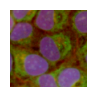

In [111]:
for i in range(len(original)):
    print(f"Original {i}")
    plt.figure(figsize=(1, 1))
    plt.imshow(original[i][:, :, [5, 1, 0]])
    plt.axis("off")
    plt.show()
    if i==3:
        break

Original 0


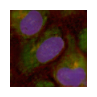

Original 1


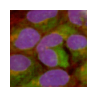

Original 2


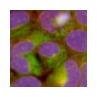

Original 3


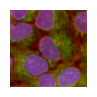

In [112]:
for i in range(len(transformed)):
    print(f"Original {i}")
    plt.figure(figsize=(1, 1))
    plt.imshow(transformed[i][:, :, [5, 1, 0]])
    plt.axis("off")
    plt.show()
    if i==3:
        break

In [113]:
original

array([[[[2.63291597e-03, 2.50828177e-01, 1.97330236e-01,
          1.57954693e-01, 1.90207362e-03, 2.44468272e-01],
         [6.76959753e-04, 1.55902267e-01, 2.34803200e-01,
          6.51077330e-02, 1.35442615e-03, 2.71682978e-01],
         [2.93540955e-03, 1.90537930e-01, 2.64524966e-01,
          6.38689101e-02, 1.31273270e-03, 2.46082127e-01],
         ...,
         [1.30927563e-03, 2.19625950e-01, 3.15625221e-01,
          1.57625735e-01, 1.79332495e-03, 2.97336906e-01],
         [3.56531143e-03, 2.23280847e-01, 3.15355778e-01,
          1.58088624e-01, 2.22218037e-03, 2.94750720e-01],
         [1.50942802e-03, 1.17542595e-01, 2.91260719e-01,
          6.97276294e-02, 3.49640846e-03, 2.72516608e-01]],

        [[2.31391191e-03, 2.50546187e-01, 2.34072715e-01,
          1.60360157e-01, 1.63120031e-03, 2.73694694e-01],
         [3.10665369e-03, 1.54228449e-01, 2.34749615e-01,
          6.37651086e-02, 4.00543213e-05, 2.71899551e-01],
         [2.23740935e-03, 2.20762014e-01, 2.6413

In [114]:
transformed

array([[[[1.00523233e-03, 1.15555823e-01, 2.31757730e-01,
          1.46054029e-02, 1.13213956e-02, 2.22144097e-01],
         [0.00000000e+00, 3.37375104e-02, 2.57482529e-01,
          6.78381324e-03, 1.06754601e-02, 2.31658995e-01],
         [1.31799579e-02, 9.61028934e-02, 2.03415155e-01,
          2.31904387e-02, 1.53877437e-02, 2.19982803e-01],
         ...,
         [8.49986076e-03, 1.02784038e-02, 1.09614253e-01,
          3.31524014e-03, 3.54757905e-03, 1.27334952e-01],
         [3.39139104e-02, 3.35554779e-02, 1.04419142e-01,
          2.16082931e-02, 4.50408459e-03, 1.28313035e-01],
         [6.89234138e-02, 0.00000000e+00, 1.34784490e-01,
          2.68724561e-03, 0.00000000e+00, 1.32663637e-01]],

        [[1.15982890e-02, 9.87299681e-02, 2.82267630e-01,
          4.73150313e-02, 2.49454975e-02, 2.90547699e-01],
         [1.68945193e-02, 9.05078053e-02, 2.64728367e-01,
          4.72929180e-02, 2.24271715e-02, 2.77735293e-01],
         [1.19858384e-02, 1.46262228e-01, 2.1437